In [21]:
import random
import numpy as np
import matplotlib.pyplot as plt
memoryLength = 4
historyKind = 2**memoryLength
strategySpaceSize = 2**historyKind
numOfAgents = 800

In [33]:
class AdaptiveAgent:
    # 初始化方法
    def __init__(self, numOfStrategies, strategySpaceSize):
        self.numOfStrategies = numOfStrategies  # 实例属性
        self.strategies = random.sample(range(0, strategySpaceSize), numOfStrategies)
        self.strategyScore = np.zeros(numOfStrategies)
        self.performance = []

    # 实例方法
    def updateStrategyScore(self, memory, result):
        for i in range(len(self.strategies)):
            strategy = self.strategies[i]
            prediction = (strategy >> memory) & 1
            if prediction == result:
                self.strategyScore[i] += 1

    # 按策略行动
    def action(self, memory):
        # 找到最大值
        max_value = np.max(self.strategyScore)
        
        # 获取所有最大值的索引
        max_indices = np.where(self.strategyScore == max_value)[0]
        
        # 随机选择一个索引
        random_index = np.random.choice(max_indices)
        
        strategy = self.strategies[random_index]
        action = (strategy >> memory) & 1
        return action

    # 随机行动
    # def action(self, memory):
    #     return random.randint(0, 1)
    
    def updatePerformance(self, update):
        if not self.performance:
            self.performance.append(update)
        else:
            self.performance.append(self.performance[-1] + update)

    def selectBestParents(self):
         # 找到最大值
        max_value = np.max(self.strategyScore)
        
        # 获取所有最大值的索引
        max_indices = np.where(self.strategyScore == max_value)[0]

        # 有两个及以上最佳策略
        if len(max_indices) >= 2:
            parents = np.random.choice(max_indices, size=2, replace=False)
        else:      #只有一个最佳
            # 创建一个布尔数组，排除最大值
            bool_mask = (self.strategyScore != max_value)
            
            # 找到次大值
            second_largest_value = np.max(self.strategyScore[bool_mask])
            # 转换为原数组的索引
            second_largest_indices = np.where(self.strategyScore == second_largest_value)[0]
            if len(second_largest_indices) >= 2:
                second_parent = np.random.choice(second_largest_indices)
                parents = [max_indices, second_parent]
            else:
                parents = [max_indices, second_largest_indices]
        return parents

    
    def selectRandomParents(self):
        parents = np.random.choice(len(self.strategies), size=2, replace=False)
        return parents
        
    def crossOver(self):
        parents = self.selectBestParents()
        rate = np.random.rand()
        point = int(historyKind*rate)
        fatherGene = self.strategies[parents[0]]
        motherGene = self.strategies[parents[1]]
        fatherGeneOne = fatherGene>>point
        motherGeneOne = motherGene>>point
        fatherGeneTwo = fatherGene % fatherGeneOne
        motherGeneTwo = motherGene % motherGeneOne
        childrenOne = fatherGeneOne<<point + motherGeneTwo
        childrenTwo = motherGeneOne<<point + fatherGeneTwo
        return childrenOne


In [35]:
numOfStrategies = 10
agent = [Agent(numOfStrategies, strategySpaceSize) for _ in range(numOfAgents)]  # 列表推导式创建对象
interTime = 5000
memory = 0
memory = int(memory)
minority = (numOfAgents-1)/2
attendHistory = np.zeros(interTime) + numOfAgents
performRecord = np.zeros(numOfAgents)
mean = np.zeros(interTime)
for i in range(interTime):
    actions = [agent[j].action(memory) for j in range(numOfAgents)]
    actions = np.array(actions)
    attendHistory[i] = np.sum(actions)
    if np.sum(actions) > minority:
        result = 0
    else:
        result = 1
        
    # 更新每个agent策略得分
    for j in range(numOfAgents):
        agent[j].updateStrategyScore(memory, result)
        
        # 更新agent performance
        if actions[j] == result:
            agent[j].updatePerformance(1)
            performRecord[j] += 1
        else:
            # agent[j].updatePerformance(-1)
            # performRecord[j] -= 1
            agent[j].updatePerformance(0)
            
    # 去中心化
    mean[i] = np.mean(performRecord)

    # 更新memory
    if attendHistory[i-memoryLength] > minority:
        popOut = 0
    else:
        popOut = 1
    memory -= popOut*2**(memoryLength-1)
    memory = int(memory)
    memory = memory << 1
    memory += result
   

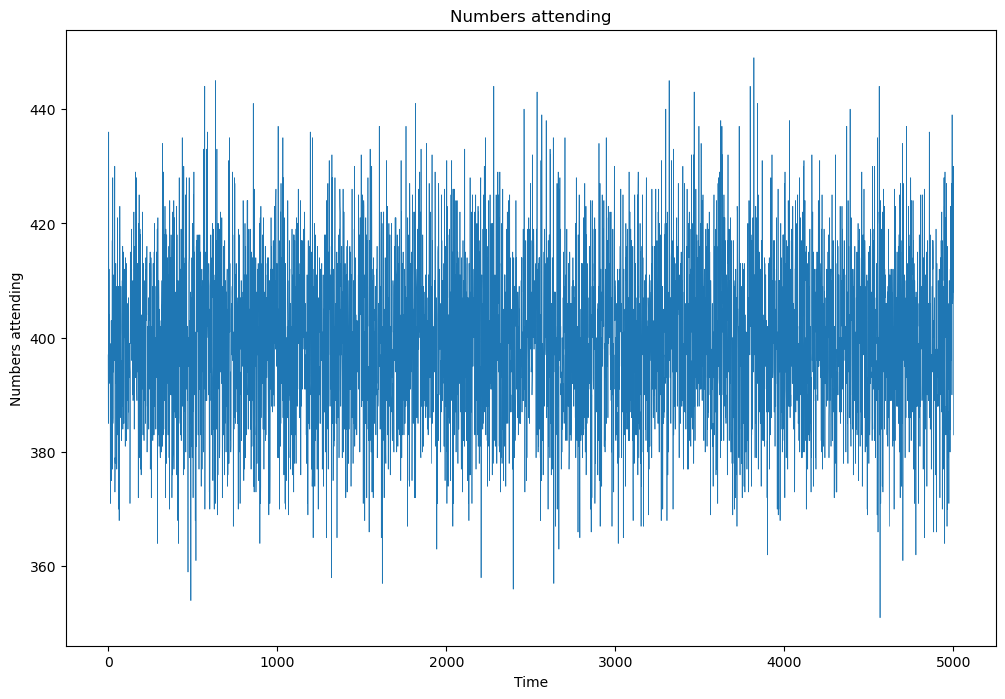

In [37]:
plt.figure(figsize = (12,8))
time = np.linspace(0,interTime + 1, interTime)
plt.plot(time, attendHistory, lw = 0.5)
plt.title('Numbers attending')
plt.xlabel('Time')
plt.ylabel('Numbers attending')
plt.show()

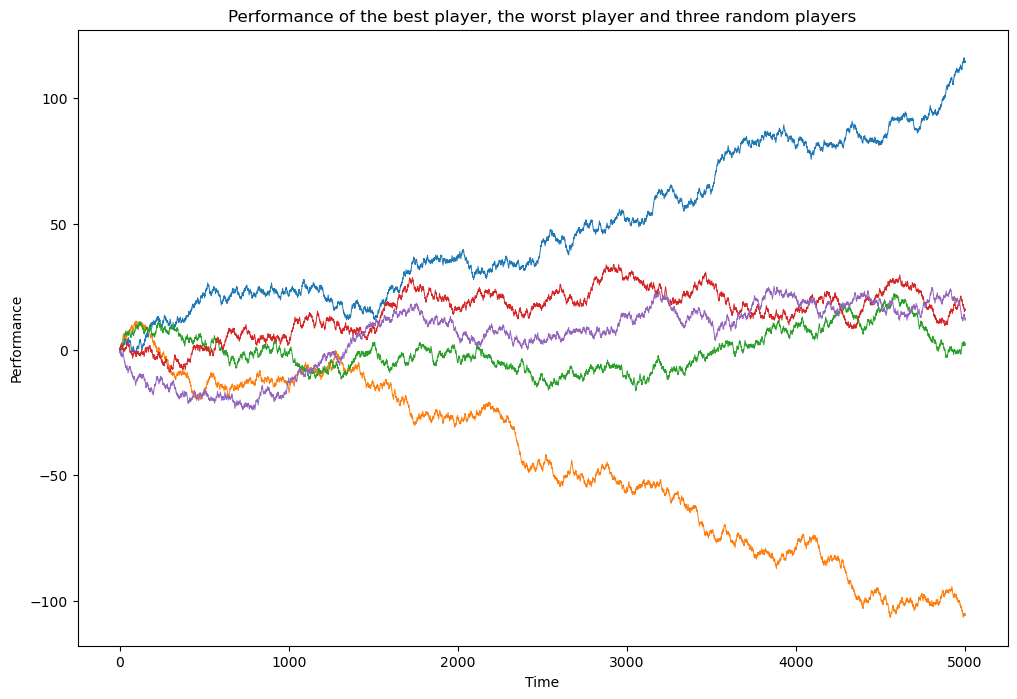

In [39]:
# 找到最大值和最小值的索引
max_index = np.argmax(performRecord)
min_index = np.argmin(performRecord)

# 创建一个列表包含所有索引
all_indices = list(range(len(performRecord)))

# 移除最大值和最小值的索引
all_indices.remove(max_index)
all_indices.remove(min_index)

# 随机选择三个不重复的索引
random_indices = np.random.choice(all_indices, size=3, replace=False)


plt.figure(figsize = (12,8))
time = np.linspace(0,interTime + 1, interTime)
plt.plot(time, agent[max_index].performance-mean, lw = 0.7)
plt.plot(time, agent[min_index].performance-mean, lw = 0.7)
plt.plot(time, agent[random_indices[0]].performance-mean, lw = 0.7)
plt.plot(time, agent[random_indices[1]].performance-mean, lw = 0.7)
plt.plot(time, agent[random_indices[2]].performance-mean, lw = 0.7)
plt.title('Performance of the best player, the worst player and three random players')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.show()

In [29]:
print(agent[max_index].strategies)
print(agent[max_index].strategyScore)

[36013, 28802, 63974, 10020, 45462, 24750, 54410, 29442, 33235, 26873]
[2499. 2501. 2501. 2501. 2500. 2499. 2500. 2502. 2501. 2499.]


In [31]:
print(agent[min_index].strategies)
print(agent[min_index].strategyScore)

[19191, 52614, 27564, 30870, 55598, 58758, 43613, 699, 63441, 15181]
[2499. 2501. 2500. 2499. 2500. 2501. 2498. 2499. 2501. 2500.]
